<a href="https://colab.research.google.com/github/rizvansaatov/Attention-based-Summarization-Approach-of-Clinical-Notes/blob/master/Notebooks/CosineSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/Dataset

/content/drive/My Drive/Dataset


Using Huggingface Library to get tokenizer and pretrained BERT model.

In [ ]:
!pip install transformers
!pip install jsonlines

     |████████████████████████████████| 1.4MB 16.3MB/s 
     |████████████████████████████████| 890kB 43.4MB/s 
     |████████████████████████████████| 2.9MB 52.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=3d64cc436ae69028485f17b2965464ebcd67103264fe50d50d2db39c5344b05f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
# Checking wether we have GPU to process tensors 
import torch
cuda_flag = torch.cuda.is_available()
if cuda_flag:
    device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(device)
print('current device = '+device_name)

current device = Tesla T4


In [ ]:
# loading 100 summaries for test
import jsonlines as js
# book = []
# with js.open("notes_labeled_dev.ndjson") as reader:
#   num = 0
#   for summary in reader:
#     if num<100:
#         book.append(summary[2])
#         num = num + 1

# clinical_notes = [" ".join( sum(book[i],[])) for i in range(100)]
Book=[]
with js.open('notes.ndjson','r') as reader:
    num = 0
    for summary in reader:
      if num<100:
        Book.append( summary)
        num = num + 1 

In [ ]:
# with js.open('notes.ndjson','r') as reader:
#   count = 0
#   for summary in reader:
#     count = count +1
# print(count)

130


In [ ]:
clinical_notes = [Book[i][2] for i in range(100)]

In [ ]:
# # clinical_notes[0]
# for lst in clinical_notes[0]:
#   print(*lst)

In [ ]:
# from transformers import BertModel, BertTokenizer # base bert

In [ ]:
#clincalBert model with pre-treained weights
global model
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [ ]:
def find_stats(note):
    padsize=0
    listsize=0
    pos,pos_longestsentence=0,0
    for lst in note:
        listsize+=1
        padsize=max(padsize,len(lst))
        if len(lst)==padsize:
            pos_longestsentence=pos
            pos+=1  
    print('Size of maximum string is ',padsize)
    print('Total number of lists ',listsize)
    print('Longest Sentence is at index ',pos_longestsentence)
    return (padsize,listsize,pos_longestsentence)


In [ ]:
(pad_size,_,_) = find_stats(clinical_notes[0])
print(pad_size)

Size of maximum string is  40
Total number of lists  214
Longest Sentence is at index  9
40


In [ ]:
from torch.nn.utils.rnn import pad_sequence
if cuda_flag:
    model = model.cuda()
model.eval();

In [ ]:
#attentions is a tuple of lists [0-12] are layers. we choose layer 2. Last layers focus all attention on CLS token
import numpy as np
def find_attentions(summary):
    input_text=[]
    for lst in summary:
      input_text.append(tokenizer.encode_plus(lst,add_special_tokens=True,is_split_into_words=True, return_tensors='pt')) # ecnode
    # do padding to make all sentences equal for BERT
    tensor_text = pad_sequence([item['input_ids'].squeeze(0) for item in input_text], batch_first=True)
    tensor_mask  = pad_sequence([item['attention_mask'].squeeze(0) for item in input_text], batch_first=True)
    tensor_ids = pad_sequence([item['token_type_ids'].squeeze(0) for item in input_text], batch_first=True) 

    if cuda_flag:
         tensor_text, token_type, attention_mask = tensor_text.cuda(), tensor_ids.cuda(), tensor_mask.cuda()
      
    with torch.no_grad():
        # loss,logits,attentions = model(tensor_text, token_type_ids = token_type, attention_mask = attention_mask)
            attentions = model(tensor_text, token_type_ids = token_type, attention_mask = attention_mask)[-1]
        # final_score=attentions[11].mean(axis=0).mean(axis=0).cpu().numpy()
            final_score  =[np.max(attentions[sen][:].cpu().numpy()) for sen in range(attentions.shape[0])]
            final_score = [0 if i<0 else i for i in final_score]
            score_norm=[i/sum(final_score) for i in final_score] 
    return final_score
        # seq_score=[]
        # for r in range(0,len(summary)):
        #       seq_score.append(final_score[r][0])
        # print(seq_score) 
        # print(len(seq_score))
        # return seq_score

#  print(attentions[11].cpu().numpy().shape)
#[hidden_State][Attention_head][Sentenceces][attention_score_from_word_in_sentence]


In [ ]:
import statistics as sc

def extract_bert_summary(summary):
  attentions = find_attentions(summary)
  lengths=[len(lst) for lst in summary]
  score=[[a]*leng for a,leng in zip(attentions,lengths)]
  score = sum(score,[])
  words = [word  for sentence in summary for word in sentence]
  extraction = [word for (word,attention) in zip(words,score) if float(attention) > sc.mean(attentions)]
  return extraction

In [ ]:
summary_clinical_notes = [extract_bert_summary(note) for note in clinical_notes]

In [ ]:
len(summary_clinical_notes)

100

In [ ]:
#Evaluation Criteria Based on probabilty distribution hypothesis sripada et al .
from scipy.stats import entropy
from scipy.spatial import distance

from collections import Counter
from collections import OrderedDict

def kld(summ, org): 
        dist_original=Counter(str(org).lower().split())
        dist_summary=Counter(str(summ).lower().split())
        q = list(dist_original.values())
        p=list(dist_summary.values())
        a=min(len(p),len(q))
        return entropy(p[0:a],qk=q[0:a])
 
def jsd(summ,org):
        dist_original=Counter(str(org).lower().split())
        dist_summary=Counter(str(summ).lower().split())
        p = list(dist_original.values())
        q = list(dist_summary.values())
        a=min(len(p),len(q))
        return distance.jensenshannon(p[0:a],q[0:a])

In [ ]:
#Cosine similarity 
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
def CosineSim(X,Y):
    X_list = word_tokenize(str(X))  
    Y_list = word_tokenize(str(Y)) 
    sw = stopwords.words('english')  
    l1 =[];l2 =[] 
    X_set = {w for w in X_list if not w in sw}  
    Y_set = {w for w in Y_list if not w in sw} 
  
    rvector = X_set.union(Y_set)  
    for w in rvector: 
      if w in X_set: l1.append(1)  
      else: l1.append(0) 
      if w in Y_set: l2.append(1) 
      else: l2.append(0) 
    c = 0
   
    for i in range(len(rvector)): 
            c+= l1[i]*l2[i] 
    cosine = c / float((sum(l1)*sum(l2))**0.5)

    return cosine


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
Original_doc =[(clinical_notes[i]) for i in range(100)]
Summary_doc =[(summary_clinical_notes[i]) for i in range(100)]

In [ ]:
print(CosineSim(Original_doc, Summary_doc))

0.9292359460634465


In [ ]:
import statistics as sc
kld_bert=[]
jsd_bert = []

for i in range(100):
  kld_bert.append(kld(summary_clinical_notes[i],clinical_notes[i]))
  jsd_bert.append(jsd(summary_clinical_notes[i],clinical_notes[i]))

print(sc.mean(kld_bert))
print(sc.mean(jsd_bert))

0.8087344779115722
0.40649206809258753


In [ ]:
Bert_freq=[CosineSim(clinical_notes[i],summary_clinical_notes[i]) for i in range(100)]

In [ ]:
print(Bert_freq)

[0.8862623724991383, 0.8883150852515187, 0.8995249464159691, 0.9135035494377431, 0.8770580193070292, 0.8731415908223376, 0.9191056765983141, 0.8657671585412482, 0.8800771608322578, 0.8979097240601465, 0.8733959656539024, 0.8693838167684602, 0.90211949193836, 0.883823953706156, 0.889189203401822, 0.8809280542726318, 0.863642935986349, 0.8833005039168608, 0.868832624773109, 0.858682615927917, 0.9078624359235917, 0.886158040994738, 0.8920664010761574, 0.9053352427915808, 0.7994612189309162, 0.8759681851745008, 0.8893435724872775, 0.7823299392067673, 0.8607285626355067, 0.802458344052446, 0.8779850877640663, 0.8652532008633532, 0.8588545769848328, 0.8415501689917787, 0.8757497755504673, 0.9000095950361682, 0.9176629354822471, 0.881451736601977, 0.8724643430254019, 0.8405668959414869, 0.8990652167748825, 0.8744394498559835, 0.8836151405984238, 0.8772315052189836, 0.9028490884011563, 0.8935145764722019, 0.8831760866327847, 0.9191732796770634, 0.9152228018000588, 0.8275598068133847, 0.9008148

In [ ]:
# values from other notebook baselines summarizer
kld_freq = [0.7199990163091441, 1.288577094003375, 0.6876781653361953, 1.0548275305953054, 0.822106467044532, 1.0250455035798383, 0.7642230697261388, 0.8861677097328216, 0.8133151448774971, 1.070300835591361, 0.8902506584557677, 1.0409563178920767, 0.9325518447723371, 0.876780478796326, 0.7527658673801978, 1.109862192707198, 0.9814609731836896, 1.3140823138880307, 0.6336290837851819, 0.5945883813485552, 0.9853710957839535, 0.6425021501485686, 0.7927687220316615, 1.0248072650693685, 0.7909853199013283, 0.917756720574602, 0.7840406497243342, 0.36351808643481, 0.7646289844561274, 0.7901441270581637, 1.3074442360423464, 1.1585353169123405, 0.8390222886295955, 0.7277708334637526, 0.9440759880626365, 1.0119889895584742, 0.4404568982928508, 0.809263712380167, 0.9257424674505709, 0.8088068380486474, 1.1703079980729523, 1.0009809316501646, 0.6645238775763517, 0.9657224564406461, 0.8211600933863579, 0.9475945948239577, 1.0045711656352914, 0.8222920904678139, 0.9173348150335361, 1.0650339501847848, 0.9150650487002507, 0.8592161332260143, 0.7760992513052745, 0.9899705820711331, 0.25402090348903744, 1.0738141312402973, 0.958779532547603, 0.8047759506636604, 0.8837316319163978, 1.0237833505131568, 1.0448370196047883, 0.7598523168375311, 0.7421577154953737, 0.7060657854315938, 0.9310896222377714, 0.7222608882096487, 1.0117940181455518, 1.235252849808724, 0.7749524468673616, 0.6028963762294497, 0.8497471330550408, 1.188247565159837, 1.1064630436808665, 0.8005052123107964, 0.943394967833588, 0.8352263506528074, 1.261395619257123, 0.9057660069747315, 0.7437664404687891, 0.8961443246169718, 0.992520711484797, 0.9310731755674274, 0.8276231800837823, 0.8482506953980145, 0.951658753833869, 0.6529169649183043, 0.6827022343894, 0.8240654539174791, 1.3381892931093735, 0.8883881871861411, 1.3539373370730008, 0.7983410280939688, 0.7374364832394635, 0.841450466192277, 0.7601875735059431, 0.49707873253014384, 0.8610639835107452, 1.0040131802807752, 1.244057337071036, 1.1587067148922152]
jsd_freq = [0.39720931225497386, 0.4852511366314636, 0.3872706804927176, 0.46340325681824046, 0.4099997986976341, 0.46005880733558646, 0.4002969489882648, 0.44234415036007135, 0.421925310099122, 0.4693768278740044, 0.4158760771563454, 0.45895034411578084, 0.4402055982830778, 0.41583161778047406, 0.3969658596406603, 0.4911221113095487, 0.445479559429233, 0.5046759063512024, 0.3713131621866397, 0.3478467357335101, 0.4340713440256459, 0.3749889088313121, 0.41151153011543545, 0.4588922511707417, 0.4091819540392327, 0.43419640905267, 0.4065440662077568, 0.2844284268589189, 0.40559652794340256, 0.4014378102932751, 0.4967820570737719, 0.4870344672921085, 0.4078101320044515, 0.4108891690505209, 0.43240798520967044, 0.44935119240437205, 0.30652719506018367, 0.4162684644669471, 0.4354268177375234, 0.39773859743967266, 0.4715521382530961, 0.447962003273332, 0.38610627249095786, 0.4315213182615697, 0.41408626881185323, 0.44327199859245164, 0.44658865113350443, 0.40915999634888267, 0.432579406441209, 0.46516287510699234, 0.43411307155006607, 0.4231658229357147, 0.3998127104906795, 0.45057579185007557, 0.2290297743715948, 0.4760834031030112, 0.4335523857629184, 0.41516752657671646, 0.43874027686937406, 0.4568945731781437, 0.47081245798217464, 0.4056472661746331, 0.3979407366977592, 0.37717446499159896, 0.4340829736581772, 0.3881235315133434, 0.44593482069341067, 0.4900066637617449, 0.4013769642616592, 0.3620793700689522, 0.42967583582364666, 0.5092855744997147, 0.4815715537389554, 0.4107153861102546, 0.4324135002174301, 0.41260020432057676, 0.47584168236171737, 0.45241197157420976, 0.39985777827917024, 0.44433796189167596, 0.4507521245052968, 0.43070964328348293, 0.4142477213322459, 0.4282527282335757, 0.4372838180953955, 0.37491735876279997, 0.3816171949760131, 0.42752970547470326, 0.4951776614304662, 0.43596184440374197, 0.5136152666821995, 0.41795562355788785, 0.4099793980911211, 0.4202847642635409, 0.4098869056748805, 0.32936378459450627, 0.4188613183589922, 0.4511300428259509, 0.48116143642937387, 0.4832579831809677]

In [ ]:
Cos_freq=[0.37873449911264595, 0.511591962121002, 0.5160920377389862, 0.53237853309578, 0.6307098176567829, 0.5395980823690434, 0.585830465035211, 0.4517484186085608, 0.5541551907299841, 0.47478146520599773, 0.47326981193966494, 0.5657751411012437, 0.6068097935395423, 0.5431802239257741, 0.4526554629827528, 0.35970995375910303, 0.4721954456494744, 0.6049474363801799, 0.47192327630498343, 0.5277467423309411, 0.5210452439509743, 0.4356201399192154, 0.5480416249497142, 0.4704283887837515, 0.5746150235583186, 0.4825185139896372, 0.4686197026389696, 0.6783321117133647, 0.5711272658345864, 0.6230853024407228, 0.5507634776637607, 0.5474433209040426, 0.4825351298075323, 0.5403329871347067, 0.46515089002174476, 0.5756121815243376, 0.6461522964751135, 0.5055902702147334, 0.5996585330875167, 0.4894087842323964, 0.629192639880048, 0.5968397216292055, 0.6153465376785454, 0.5727561831967167, 0.5700511506745045, 0.43195997059111507, 0.4597056568540895, 0.5791303073015641, 0.5941569623555261, 0.6265043507526986, 0.5735964583646965, 0.5201684336683533, 0.5127579088389793, 0.3016253016254525, 0.526561958506067, 0.48786320489844354, 0.5062525322575727, 0.45873903449195125, 0.5587282650829387, 0.5901534478524492, 0.6029002037284751, 0.3140061809584996, 0.5131362842079723, 0.5596401382328887, 0.6233359295312342, 0.5633570822432309, 0.5495760868583911, 0.5594256422318549, 0.39240134112334263, 0.2414990172072478, 0.49395743598288266, 0.3012923025259113, 0.44296770563257803, 0.5200456336089135, 0.6328840152621481, 0.5668369959749481, 0.309669689838072, 0.3193520527015302, 0.457783936607728, 0.3297917719589623, 0.45880138886915606, 0.5831164740610193, 0.6524913237248691, 0.4399118639772092, 0.48128965949366764, 0.6537649526320002, 0.4697276141771697, 0.5817411457789681, 0.5479231973553604, 0.6230038927375123, 0.5098574682356665, 0.36951638790105673, 0.532744157132579, 0.5848177787307142, 0.4649301684792451, 0.7528635388416589, 0.5580293757607879, 0.5461427596611319, 0.4865069763439368, 0.5026379820481834]


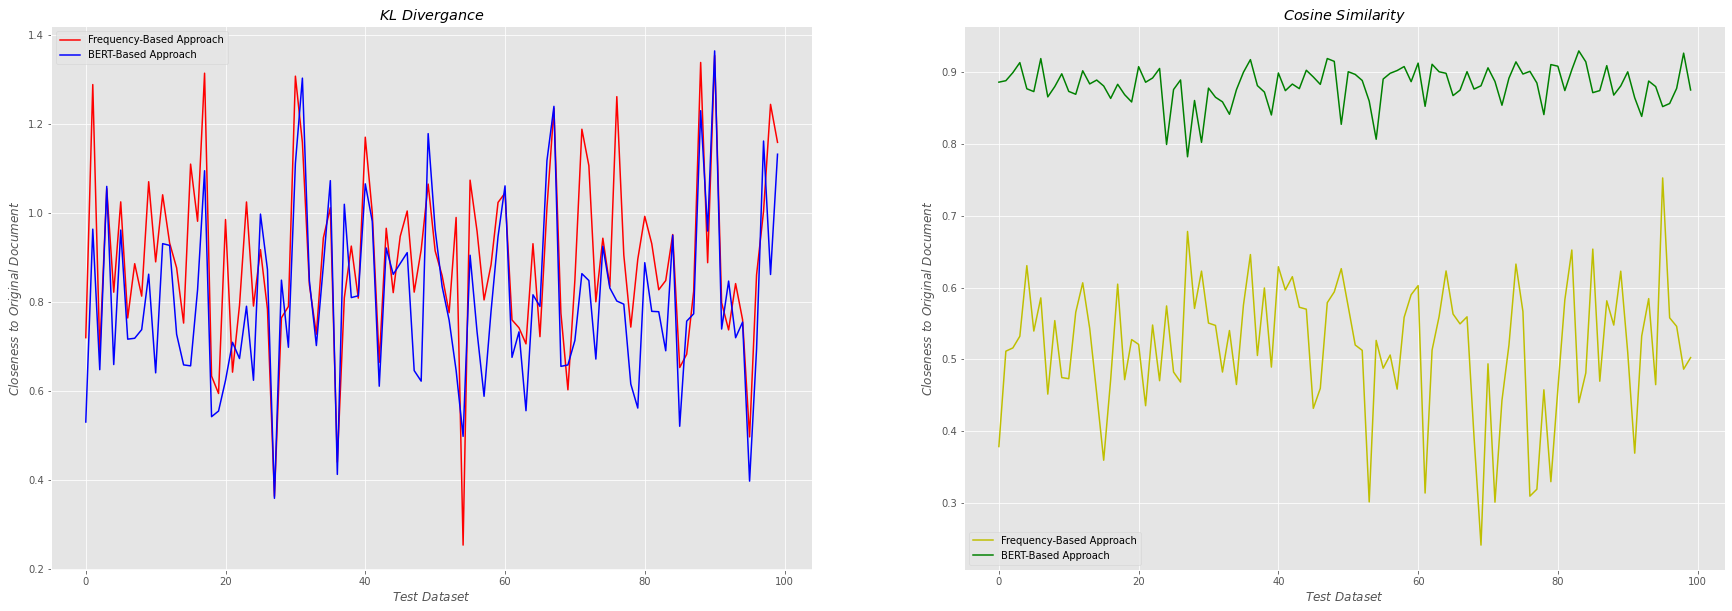

In [ ]:
plt.figure(figsize=(30,10))

plt.subplot(121)
plt.style.use('ggplot')
plt.plot(kld_freq,'r',label= "Frequency-Based Approach")
plt.plot(kld_bert,'b',label="BERT-Based Approach")
plt.xlabel("$Test\ Dataset$")
plt.ylabel("$Closeness\ to\ Original\ Document$")
plt.title("$KL\  Divergance$")
plt.legend()

plt.subplot(122)
plt.style.use('ggplot')
plt.plot(Cos_freq,'y',label= "Frequency-Based Approach")
plt.plot(Bert_freq,'g',label="BERT-Based Approach")

plt.xlabel("$Test\ Dataset$")
plt.ylabel("$Closeness\ to\ Original\ Document$")
plt.title("$Cosine\  Similarity$")
plt.legend()
plt.savefig("evaluation.jpg")
plt.show()





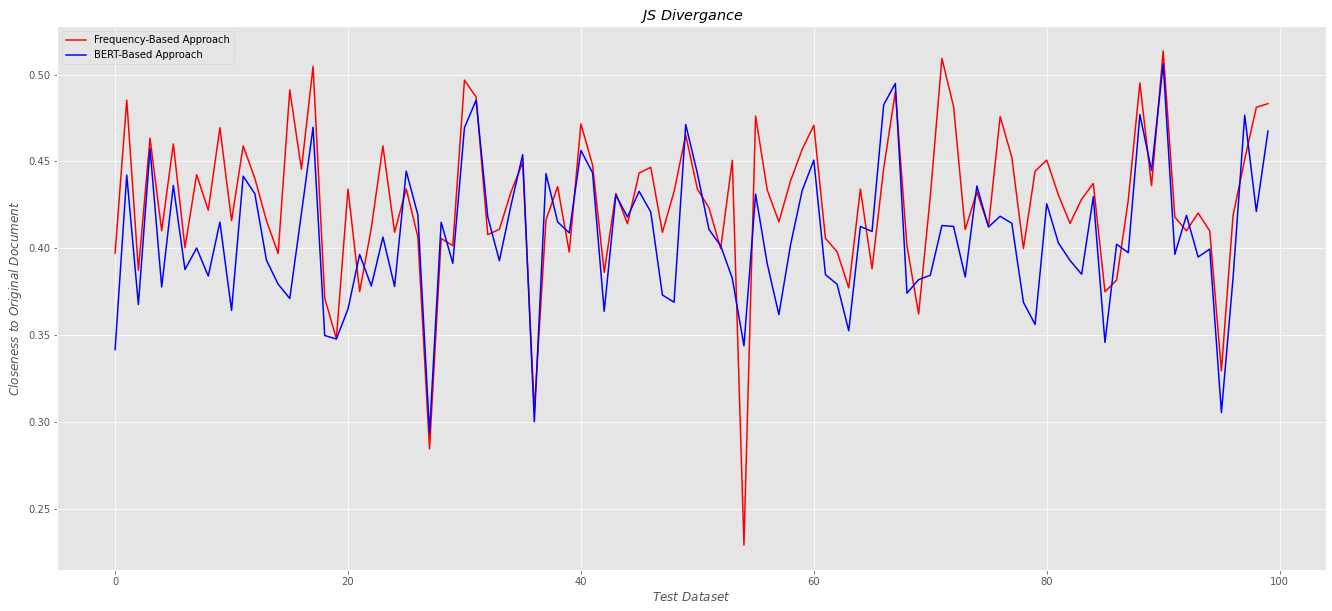

In [ ]:
plt.figure(figsize=(50,10))
plt.subplot(122)
plt.style.use('ggplot')
plt.plot(jsd_freq,'r',label= "Frequency-Based Approach")
plt.plot(jsd_bert,'b',label="BERT-Based Approach")
plt.xlabel("$Test\ Dataset$")
plt.ylabel("$Closeness\ to\ Original\ Document$")
plt.title("$JS\  Divergance$")
plt.legend()
plt.savefig("evaluation.jpg")
plt.show()




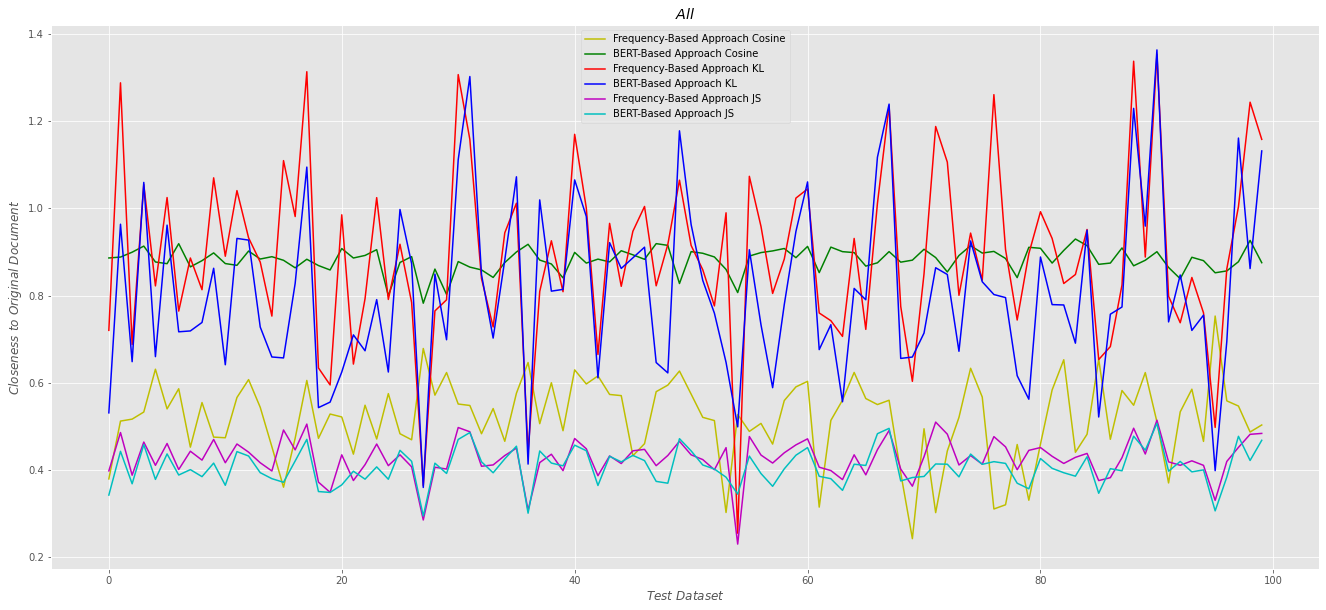

In [ ]:
plt.figure(figsize=(50,10))
plt.subplot(121)
plt.style.use('ggplot')

plt.plot(Cos_freq,'y',label= "Frequency-Based Approach Cosine")
plt.plot(Bert_freq,'g',label="BERT-Based Approach Cosine")
plt.plot(kld_freq,'r',label= "Frequency-Based Approach KL")
plt.plot(kld_bert,'b',label="BERT-Based Approach KL")
plt.plot(jsd_freq,'m',label= "Frequency-Based Approach JS")
plt.plot(jsd_bert,'c',label="BERT-Based Approach JS")
plt.xlabel("$Test\ Dataset$")
plt.ylabel("$Closeness\ to\ Original\ Document$")
plt.title("$All\  $")
plt.legend()
plt.savefig("evaluation.jpg")
plt.show()


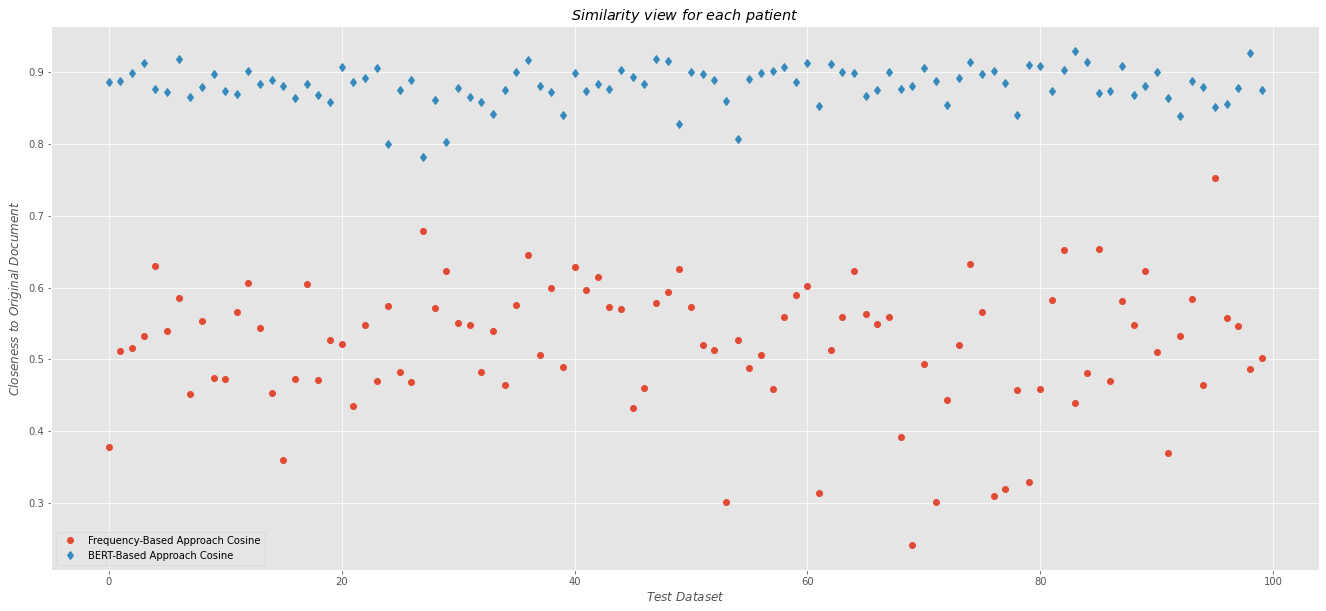

In [ ]:
plt.figure(figsize=(50,10))
plt.subplot(121)
plt.style.use('ggplot')

plt.plot(Cos_freq,'o',label= "Frequency-Based Approach Cosine")
plt.plot(Bert_freq,'d',label="BERT-Based Approach Cosine")

plt.xlabel("$Test\ Dataset$")
plt.ylabel("$Closeness\ to\ Original\ Document$")
plt.title("$Similarity\ view\  for\ each\ patient$")
plt.legend()
plt.savefig("evaluation.jpg")
plt.show()


#Baseline Approaches

In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_lg
!pip install jsonlines

Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.3.5)
     |████████████████████████████████| 782.7MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.3.1-cp36-none-any.whl size=782936125 sha256=7cd3cd4cef23276347ac64f4b13473779f59a68e34ffdb9844354bf3ea48a85c
  Stored in directory: /tmp/pip-ephem-wheel-cache-48hu91e8/wheels/ce/4d/1b/bc6cabb6df139c5f0318927be3ae9e51363fb44d6ea328d3f4
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:

import jsonlines as js
book = []
with js.open("notes.ndjson") as reader:
  num = 0
  for summary in reader:
    if num<100:
        book.append(summary[2])
        num = num + 1

clinical_notesb = [" ".join( sum(book[i],[])) for i in range(100)]

In [ ]:
print(len(clinical_notesb))

100


In [ ]:
from scipy.stats import entropy
from scipy.spatial import distance

from collections import Counter
from collections import OrderedDict

def kld(summ, org): 
        dist_original=Counter(org.lower().split())
        dist_summary=Counter(summ.lower().split())
        q = list(dist_original.values())
        p=list(dist_summary.values())
        a=min(len(p),len(q))
        return entropy(p[0:a],qk=q[0:a])
 
def jsd(summ,org):
        dist_original=Counter(org.lower().split())
        dist_summary=Counter(summ.lower().split())
        p = list(dist_original.values())
        q = list(dist_summary.values())
        a=min(len(p),len(q))
        return distance.jensenshannon(p[0:a],q[0:a])

###**Frequency** **Based** **Summarizer**

In [ ]:
import spacy
from collections import Counter
from string import punctuation
import en_core_web_lg
nlp = en_core_web_lg.load()
# nlp = spacy.load("en_core_web_lg")

In [ ]:
# Function using POS summarization based on idea similar to Edmundson et al
def summarize(text):
    keyword = []
    pos_tag = ['PROPN', 'ADJ', 'NOUN', 'VERB']
    doc = nlp(text.lower())
    for token in doc:
        if(token.text in nlp.Defaults.stop_words or token.text in punctuation):
            continue
        if(token.pos_ in pos_tag):
            keyword.append(token.text)
    
    freq_word = Counter(keyword)
    max_freq = Counter(keyword).most_common(1)[0][1]
    for w in freq_word:
        freq_word[w] = (freq_word[w]/max_freq)
        
    sent_strength={}
    for sent in doc.sents:
        for word in sent:
            if word.text in freq_word.keys():
                if sent in sent_strength.keys():
                    sent_strength[sent]+=freq_word[word.text]
                else:
                    sent_strength[sent]=freq_word[word.text] 
    summary = []
    
    sorted_x = sorted(sent_strength.items(), key=lambda kv: kv[1], reverse=True)
    limit=len(sorted_x)/15
    counter = 0
    for i in range(len(sorted_x)):
        summary.append(str(sorted_x[i][0]).capitalize())

        counter += 1
        if(counter >= limit):
            break
            
    return ' '.join(summary)


In [ ]:
summary=[summarize(note) for note in clinical_notesb]
summary[0]

'Meq tablet er particles crystals sig one tablet er particles crystals po once a day for days disp tablet er particles crystals s refills discharge disposition home with service facility hospitaltoken vna discharge diagnosis mitral regurgitation coronary artery artery disease s p mitral valve repair coronary artery Daily disp tablet s refills tramadol mg tablet sig one tablet po q6h every hours as needed for pain disp tablet s refills acetaminophen Mg tablet sig two tablet po q6h every hours as needed for pain tablet s senna mg tablet Tartrate mg tablet sig three tablet po tid times a day disp tablet s refills potassium chloride Atorvastatin mg tablet sig one tablet po daily daily disp tablet s refills Furosemide mg tablet sig one tablet po once a day for days disp tablet s refills X past medical history copd secondary to asbestos exposure as a child arhtritis bil knees r arm cataracts bil headaches lactose intolerance s p r wrist and elbow surgery discharge condition alert and oriente

In [ ]:
len(summary[0])


1110

In [ ]:

from collections import Counter
from collections import OrderedDict
#  forming a frequency distribution for words
dist_original=Counter(clinical_notes[0].lower().split())
dis_summary=Counter(summary[0].lower().split())

print(list(dist_original.values()))
print(list(dis_summary.values()))

[3, 3, 12, 7, 5, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 2, 16, 2, 3, 1, 1, 3, 8, 2, 1, 8, 5, 3, 4, 6, 3, 3, 17, 11, 1, 1, 15, 1, 2, 5, 1, 1, 1, 1, 1, 1, 12, 1, 12, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 4, 1, 1, 1, 3, 1, 3, 16, 3, 3, 1, 18, 1, 2, 2, 4, 2, 2, 2, 2, 5, 12, 2, 2, 5, 2, 4, 2, 2, 2, 2, 2, 11, 4, 2, 2, 6, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 11, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 2, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 11, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 4, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 15, 3, 18, 1, 1, 7, 1, 2, 14, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 4, 1, 1, 1, 2, 2, 2, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 15, 3, 1, 1, 1, 1, 4, 1, 8, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1

In [ ]:
kld_freq=[kld(clinical_notes[i],summary[i]) for i in range(100)]
print(kld_freq)
jsd_freq=[jsd(summ,org) for org,summ in zip(clinical_notes,summary)]
print(jsd_freq)

[0.7104267569442126, 1.0816436372232, 0.7186388988855743, 1.1433484593290981, 0.8825713588245028, 1.3144409119051559, 0.8810244160313474, 0.7476607720078402, 0.9319430783295284, 1.0692260907893496, 0.6410205544777983, 1.1008083928611487, 1.09545302159411, 0.6943503007901376, 0.7200326266798652, 0.9854439653384617, 1.1882728605827202, 1.1251569323840316, 0.5836796054101492, 0.44438916648308896, 0.9051862851764119, 0.7037149815326806, 0.9340437257722839, 0.9292025376137216, 0.8291029334155311, 0.39026460854099304, 0.9375754798159874, 0.44250783185688625, 0.888182229199563, 0.6616908677684561, 1.2538760017728092, 1.4927906331862681, 0.7403778301478742, 0.6634560835256142, 0.7742336312991589, 0.9546612419048383, 0.5137091542839093, 0.9373925508729215, 0.8974287315813958, 0.6580095136596907, 1.2025646178237075, 0.9934914919240819, 0.7511610146998857, 0.7807947257750163, 0.9355074256937403, 1.0816344379606397, 0.8974849242914027, 0.8142891421731913, 0.8794380195681988, 1.1402616210637344, 1.

In [ ]:
import statistics as sc
print(sc.mean(kld_freq))
print(sc.mean(jsd_freq))

0.8946931127232314
0.42582082596884774


In [ ]:
Orginal_doc1 =[(clinical_notes[i]) for i in range(100)]
Summary_doc1 =[(summary[i]) for i in range(100)]

In [ ]:
print(CosineSim(Orginal_doc1,Summary_doc1))

0.6992053407495786


In [ ]:
cos_freq=[CosineSim(clinical_notes[i],summary[i]) for i in range(100)]

In [ ]:
print(cos_freq)

[0.37873449911264595, 0.511591962121002, 0.5160920377389862, 0.53237853309578, 0.6307098176567829, 0.5395980823690434, 0.585830465035211, 0.4517484186085608, 0.5541551907299841, 0.47478146520599773, 0.47326981193966494, 0.5657751411012437, 0.6068097935395423, 0.5431802239257741, 0.4526554629827528, 0.35970995375910303, 0.4721954456494744, 0.6049474363801799, 0.47192327630498343, 0.5277467423309411, 0.5210452439509743, 0.4356201399192154, 0.5480416249497142, 0.4704283887837515, 0.5746150235583186, 0.4825185139896372, 0.4686197026389696, 0.6783321117133647, 0.5711272658345864, 0.6230853024407228, 0.5507634776637607, 0.5474433209040426, 0.4825351298075323, 0.5403329871347067, 0.46515089002174476, 0.5756121815243376, 0.6461522964751135, 0.5055902702147334, 0.5996585330875167, 0.4894087842323964, 0.629192639880048, 0.5968397216292055, 0.6153465376785454, 0.5727561831967167, 0.5700511506745045, 0.43195997059111507, 0.4597056568540895, 0.5791303073015641, 0.5941569623555261, 0.626504350752698

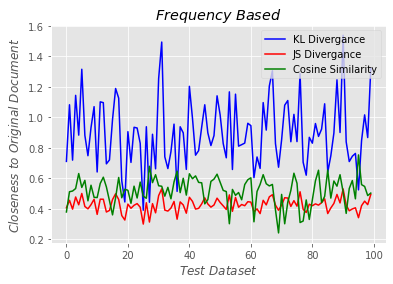

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.plot(kld_freq,'b',label= "KL Divergance")
plt.plot(jsd_freq,'r',label= "JS Divergance")
plt.plot(cos_freq,'g',label="Cosine Similarity")
plt.xlabel("$Test\ Dataset$")
plt.ylabel("$Closeness\ to\ Original\ Document$")
plt.title("$Frequency\  Based$")
plt.legend(loc= "upper right")
plt.savefig("jsd.jpg")
plt.show()